# Coding your own RNN

Using this pre-filled notebook, we will code our own RNN for sentence classification. For now, we'll keep using IMDB, as the goal of this part is to understand how an RNN works.

Unlike our previous lab, we will also learn the embedding layer. Which means we need to deal with vocabulary by ourselves.

In [1]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab, build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset
We load the dataset and split the training set in a stratified train/validation set.

In [2]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

((20000, 2), (5000, 2), (25000, 2))

## Vocabulary (1 point)

**\[1 point\]** Build your own vocabulary. The [example provided in torchtext documentation](https://pytorch.org/text/stable/vocab.html#id1) might be of help.
* Don't forge to setup the `min_freq` parameter to not include unfrequent noise.
* You will need a tokenizer. Reuse the `basic_english` one from the our previous lab.
* For an RNN we need two special tokens: `<unk>`, for unknown words, and `<pad>` for padding.

In [3]:
tokenizer = get_tokenizer("basic_english", language='en')
def yield_tokens(data):
    for doc in data:
        yield tokenizer(doc['text'])
vocabulary = build_vocab_from_iterator(yield_tokens(train_df), specials=["<unk>", "<pad>"], min_freq=1)
vocabulary.set_default_index(vocabulary["<unk>"])

## Vectorize and batch the input (3 points)

As seen in class, our model should take one-hot encoded vectors corresponding to the each token vocabulary id. However, computing a vector x matrix multiplication for every input is unnecessarily costly. Multiplying a one-hot vector with a matrix is the equivalent of taking one row of the matrix. In pyTorch, we provide ids for each token which will be used as input to an `nn.Embedding` layer. The id is simply the row in the embedding matrix.

**\[1 point\]** Fill the `vectorize_text` function returning a 1D torch tensor of `torch.long` for each input text.

In [4]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    tokens = tokenizer(text)
    ids = vocabulary.forward(tokens)
    return torch.tensor(ids, dtype=torch.long)

In [5]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

Check the function is working correctly, especially it should return the right special id for unknown words.

In [6]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([  56, 2928,   13,  246,  521,   50,    3,    3,    3,    0])

In [7]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

To speed up the training process, we turn the inputs into batches, as we did last time. For batches to work, every line must have the same lengths. Last time, it was implicit as only a vector (the average of all embeddings) was provided. This time, every line has the length of a different review.

To go around this problem, we use padding. So every line within a batch is padded to the length of its longest element.

* **\[1 point\]** Fill the data generator function.
* **\[1 point\]** On which side should you pad and why?

In [8]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)

    # Find max length
    len_max = 0
    for x in X:
        len_max = max(len_max, len(x))

    for batch in range(0, len(X), batch_size):
        batch_X = X[batch:batch + batch_size]
        batch_y = y[batch:batch + batch_size]

        batch_y = torch.tensor(batch_y)
        
        # Padding
        for vec_i in range(len(batch_X)):
            if len_max - len(batch_X[vec_i]) != 0:
                padding = torch.full((len_max - len(batch_X[vec_i]), ), pad_id)
                batch_X[vec_i] = torch.cat((padding, batch_X[vec_i]))

        yield batch_X, batch_y

In [9]:
pad_token = "<pad>"
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

## Classifier (3 points)

**\[3 points\]** Code your own RNN. Fill the `RNN` class correctly. Remember, an RNN has 3 elements.
* An embedding layer to turn one-hot vectors into dense vectors.
* A linear layer which takes the concatenation of the current embedding and hidden layer and send it to the hidden layer of our next step.
  * `embedding_size + hidden_size -> hidden_size`
* A linear layer which takes the concatenation of the current embedding and hidden layer and send it to the output.
  * `embedding_size + hidden_size -> 1`
* The provided `init_hidden` function sho

In [10]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.W = nn.Linear(in_features=embedding_dim, out_features=hidden_size)
        self.U = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.V = nn.Linear(in_features=hidden_size, out_features=1)

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, device=self.embedding.weight.device)

    def forward(self, x):
        hidden = self.init_hidden(x.shape[0])
        for t in range(x.shape[1]):
            hidden = torch.tanh(self.W(self.embedding(x[:, t])) + self.U(hidden))
        return self.V(hidden).squeeze()


## Training (2 points)

Training is a bit different than usual. We will need to sequentially (but in "batch parallel") go through an input, keeping track of the hidden layer, and use the last output as prediction.

**\[2 point\]** Code the training loop.
* Note that for each batch, you need to loop through the whole input and use the output of the last token as input to your criterion.
* Keep the best model evaluated on the validation set.
* Plot the training and validation losses.
* Training will take some time (~30 min on a T4 GPU). Make sure your results appear in the notebook.

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [12]:
n_embedding = 32
n_hidden = 64
model = RNN(len(vocabulary.get_itos()), n_embedding, n_hidden).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

Epoch 1/10 - loss: 0.6386 - val_loss: 0.5539
Epoch 2/10 - loss: 0.5949 - val_loss: 0.3762
Epoch 3/10 - loss: 0.5049 - val_loss: 0.4360
Epoch 4/10 - loss: 0.4310 - val_loss: 1.1464
Epoch 5/10 - loss: 0.4452 - val_loss: 0.8810
Epoch 6/10 - loss: 0.5498 - val_loss: 0.3529
Epoch 7/10 - loss: 0.4477 - val_loss: 0.4152
Epoch 8/10 - loss: 0.5937 - val_loss: 0.7191
Epoch 9/10 - loss: 0.4733 - val_loss: 0.5494
Epoch 10/10 - loss: 0.2991 - val_loss: 0.3470


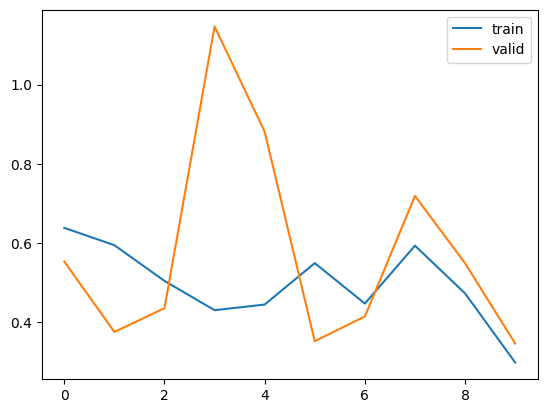

In [13]:
EPOCH = 10

losses = []
val_losses = []


for epoch in range(EPOCH):
    model.train()
    for batch_X, batch_y in train_gen():
        batch_X = torch.stack(batch_X).to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        pred = model(batch_X)
        loss = criterion(pred, batch_y.float())
        loss.backward()
        optimizer.step()

    losses.append(loss.item())

    model.eval()
    for batch_X, batch_y in valid_gen():
        batch_X = torch.stack(batch_X).to(device)
        batch_y = batch_y.to(device)

        pred = model(batch_X)
        loss = criterion(pred, batch_y.float())

    val_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{EPOCH} - loss: {losses[-1]:.4f} - val_loss: {val_losses[-1]:.4f}")

plt.plot(losses, label="train")
plt.plot(val_losses, label="valid")
plt.legend()

## Evaluation (1 point)

* **\[1 point\]** Compute the accuracy for all 3 splits.

In [14]:
def accuracy(split, model):
    model.eval()
    correct = 0
    nb_iter = 0
    for batch_X, batch_y in split():
        batch_X = torch.stack(batch_X).to(device)
        batch_y = batch_y.to(device)

        pred = model(batch_X)
        pred = torch.sigmoid(pred).round().long()
        correct += (pred == batch_y).sum().item()
        nb_iter += batch_y.size(0)
    return correct / nb_iter

print(f"Train accuracy: {accuracy(train_gen, model):.4f}")
print(f"Valid accuracy: {accuracy(valid_gen, model):.4f}")
print(f"Test accuracy: {accuracy(test_gen, model):.4f}")

Train accuracy: 0.8601
Valid accuracy: 0.7494
Test accuracy: 0.7509
